<a href="https://www.kaggle.com/code/shapniljoy/housing-price-bangladesh?scriptVersionId=264253416" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **(1) Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import optuna
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder,PowerTransformer
from sklearn.compose import ColumnTransformer,TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold,RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import optuna
from plotly.io import show


# **(2) Data Cleaning**

In [2]:
df = pd.read_csv('/kaggle/input/house-price-bangladesh/house_price_bd.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             3865 non-null   object 
 1   Bedrooms          2864 non-null   float64
 2   Bathrooms         2864 non-null   float64
 3   Floor_no          3181 non-null   object 
 4   Occupancy_status  3766 non-null   object 
 5   Floor_area        3766 non-null   float64
 6   City              3865 non-null   object 
 7   Price_in_taka     3865 non-null   object 
 8   Location          3859 non-null   object 
dtypes: float64(3), object(6)
memory usage: 271.9+ KB


In [4]:
df.head()

,Title,Bedrooms,Bathrooms,Floor_no,Occupancy_status,Floor_area,City,Price_in_taka,Location
0,We Are Offering You A Very Spacious 1960 Sq Ft...,3.0,4.0,3,vacant,1960.0,dhaka,"৳39,000,000","Gulshan 1, Gulshan"
1,Valuable 1705 Square Feet Apartment Is Ready T...,3.0,3.0,1,vacant,1705.0,dhaka,"৳16,900,000","Lake Circus Road, Kalabagan"
2,1370 square feet apartment is ready to sale in...,3.0,3.0,6,vacant,1370.0,dhaka,"৳12,500,000","Shukrabad, Dhanmondi"
3,2125 Square Feet Apartment For Sale In Bashund...,3.0,3.0,4,vacant,2125.0,dhaka,"৳20,000,000","Block L, Bashundhara R-A"
4,Buy This 2687 Square Feet Flat In The Nice Are...,3.0,3.0,4,vacant,2687.0,dhaka,"৳47,500,000","Road No 25, Banani"


In [5]:
df = pd.read_csv('/kaggle/input/house-price-bangladesh/house_price_bd.csv')

In [6]:
df.shape

(3865, 9)

There are **3865** rows (House Informations)

In [7]:
df['Location'].str.split(',').str.get(1).nunique()

106

 There are **106** unique locations

In [8]:
df['location_area'] = df['Location'].str.split(',').str.get(1).str.lower()

## Location
Replacing   
(1)The (r-a) from basundhara r-a  
(2) The ward numbers from specific wards, such as "9 no. pahartoli ward" becomes only pahartoli ward  
(3) And removing the whitespaces using str.strip()    

In [9]:
df['location_area'] = df['location_area'].str.replace('r-a','').str.replace(r'\b\d+\s*no\.?\s*','',regex=True,flags=re.IGNORECASE).str.strip()

## Price_in_taka
(1) Removing the ৳ from prices   
(2) convert the values in Crores  
(3) rounding up the values to 2

In [10]:
def convert_to_crores(x):
    converted = (x/10000000)
    return converted

In [11]:
df['Price_in_Cr'] = df['Price_in_taka'].str.replace('৳','').str.replace(',','').str.strip().astype(float).apply(lambda x:convert_to_crores(x)).round(2)

In [12]:
df.drop(['Price_in_taka'],axis=1,inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             3865 non-null   object 
 1   Bedrooms          2864 non-null   float64
 2   Bathrooms         2864 non-null   float64
 3   Floor_no          3181 non-null   object 
 4   Occupancy_status  3766 non-null   object 
 5   Floor_area        3766 non-null   float64
 6   City              3865 non-null   object 
 7   Location          3859 non-null   object 
 8   location_area     3828 non-null   object 
 9   Price_in_Cr       3865 non-null   float64
dtypes: float64(4), object(6)
memory usage: 302.1+ KB


## City
Replacing the "-city" word from narayanganj  
There are **5** cities 

In [14]:
df['City'] = df['City'].str.replace('-city','').str.strip()

In [15]:
df['City'].value_counts()

City
dhaka          1650
chattogram     1470
narayanganj     420
gazipur         180
cumilla         145
Name: count, dtype: int64

## Floor_no

In [16]:
df['Floor_no'].value_counts()

Floor_no
1                       532
4                       418
5                       402
2                       397
3                       366
6                       316
7                       252
8                       228
9                       167
10                       30
11                       26
12                       19
13                        8
Merin City - Purbach      6
14                        2
8th                       2
4th to 8th Backside       2
1st                       1
A1,A2,A3,A4,A5,A6,A7      1
0+7                       1
1F                        1
18                        1
5th                       1
17                        1
G+7                       1
Name: count, dtype: int64

In [17]:
df['Floor_no'].str.strip()

0       3
1       1
2       6
3       4
4       4
       ..
3860    8
3861    7
3862    9
3863    9
3864    8
Name: Floor_no, Length: 3865, dtype: object

Droping where floor_no = "Merin City - Purbach" because they seems to like outliers

In [18]:
df = df[~df['Floor_no'].str.contains('Merin City - Purbach',na=False)]

Removing all the problematic rows with isin() function

In [19]:
rare_floor = df['Floor_no'].value_counts()[df['Floor_no'].value_counts()<=2].index

In [20]:
df = df[~df['Floor_no'].isin(rare_floor)]

In [21]:
df['Floor_no'].value_counts()

Floor_no
1     532
4     418
5     402
2     397
3     366
6     316
7     252
8     228
9     167
10     30
11     26
12     19
13      8
Name: count, dtype: int64

## Occupancy_status
This is the most useless column , might drop it

In [22]:
df['Occupancy_status'].value_counts()

Occupancy_status
vacant      3743
occupied       3
Name: count, dtype: int64

## Bedrooms

In [23]:
df['Bedrooms'].value_counts()

Bedrooms
3.0     2184
2.0      405
4.0      219
7.0        8
5.0        5
16.0       5
8.0        4
1.0        3
6.0        3
18.0       2
33.0       2
50.0       2
23.0       2
21.0       2
22.0       2
13.0       1
20.0       1
27.0       1
15.0       1
Name: count, dtype: int64

## Bathrooms

In [24]:
df['Bathrooms'].value_counts()

Bathrooms
3.0     1758
2.0      651
4.0      323
5.0       65
1.0       22
10.0      21
8.0        8
6.0        4
Name: count, dtype: int64

In [25]:
df.sample(3)

,Title,Bedrooms,Bathrooms,Floor_no,Occupancy_status,Floor_area,City,Location,location_area,Price_in_Cr
893,Buy This 772 Sq Ft Apartment In Mirpur-10,2.0,2.0,8,vacant,772.0,dhaka,"Section 10, Mirpur",mirpur,0.43
718,A 1550 Sq Ft Flat Is Here For Sale At Khilbari...,3.0,3.0,6,vacant,1550.0,dhaka,"Khilbari Tek, Badda",badda,1.08
1153,Grab This 1360 Sq Ft Apartment For Sale In Pal...,3.0,3.0,3,vacant,1360.0,dhaka,"Pallabi, Mirpur",mirpur,1.39


In [26]:
df.to_csv('house_price_cleaned.csv',index=False)

# **(3) Feature Engineering-1**

In [27]:
df = pd.read_csv('house_price_cleaned.csv')

Creating new boolean features that contains specific words   
for commercial space otherwise residential space  

In [28]:
df['is_commercial'] = df['Title'].str.contains('office|shop|commercial',case=False,na=False).astype(float)

In [29]:
df['is_commercial'].value_counts()

is_commercial
0.0    3408
1.0     437
Name: count, dtype: int64

In [30]:
df['is_residential'] = df['is_commercial'] == 0

In [31]:
df['is_residential'] = df['is_residential'].astype(float)

In [32]:
df = df[~df['Title'].str.contains('plot|building',case=False,na=False)]


## price per sqft

In [33]:
df['Price_per_sqft'] = ((df['Price_in_Cr']*10000000)/df['Floor_area']).round(2)

In [34]:
df['Floor_no'].value_counts()

Floor_no
1.0     523
4.0     412
5.0     401
2.0     396
3.0     366
6.0     313
7.0     252
8.0     228
9.0     167
10.0     30
11.0     26
12.0     19
13.0      8
Name: count, dtype: int64

In [35]:
df['floor_level'] = pd.cut(df['Floor_no'],bins=[0,3,8,13],labels=['low','medium','high'])

In [36]:
df['floor_level'].value_counts()

floor_level
medium    1606
low       1285
high       250
Name: count, dtype: int64

In [37]:
df.columns

Index(['Title', 'Bedrooms', 'Bathrooms', 'Floor_no', 'Occupancy_status',
       'Floor_area', 'City', 'Location', 'location_area', 'Price_in_Cr',
       'is_commercial', 'is_residential', 'Price_per_sqft', 'floor_level'],
      dtype='object')

In [38]:
df.to_csv('feature_engineered.csv',index=False)

# **(4) EDA-1**

In [39]:
df = pd.read_csv('feature_engineered.csv')

## (a) Univariate Analysis

## Bedrooms

(1) There are 993 missing values  
(2) Almost 75% of flat has 3 bedrooms


In [40]:
df['Bedrooms'].isnull().sum()

474

In [41]:
fig  = px.pie(df['Bedrooms'].value_counts(),values=df['Bedrooms'].value_counts(),
names=df['Bedrooms'].value_counts().index,hole=0.2,width=500,height=500)
fig.show()

## Bathrooms
(1) There are 993 missing values  
(2) Almost 60% flats has 3 bedrooms

In [42]:
df['Bathrooms'].isnull().sum()

474

In [43]:
px.pie(df['Bathrooms'].value_counts(),values=df['Bathrooms'].value_counts(),
names=df['Bathrooms'].value_counts().index,hole=0.2,width=500,height=500).show()

## floor level
(1) 684 Missing Values

In [44]:
df['floor_level'].isnull().sum()

153

In [45]:
fig = px.pie(df['floor_level'].value_counts(),values=df['floor_level'].value_counts(),
       names=df['floor_level'].value_counts().index,hole=0.0,width=600,height=600)
fig.show()

## Floor Area
(1) 99 Missing values  
(2) Huge level of outlier

In [46]:
df['Floor_area'].isnull().sum()

70

39.88914048608314

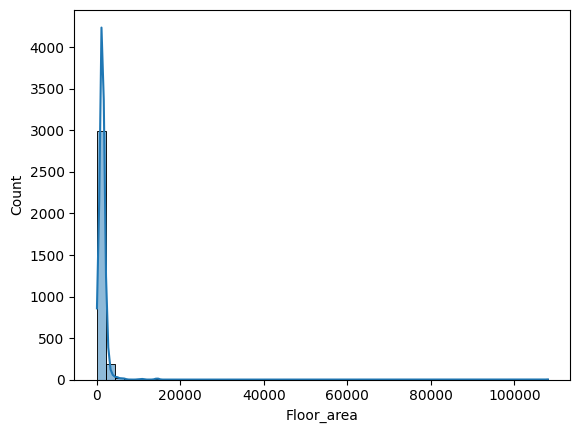

In [47]:
sns.histplot(df['Floor_area'],kde=True,bins=50)
df['Floor_area'].skew()

In [48]:
px.box(df,x='Floor_area',width=1000,height=500)

## City

In [49]:
df['City'].isnull().sum()

0

In [50]:
px.pie(df['City'].value_counts(),values=df['City'].value_counts(),names=df['City'].value_counts().index,hole=0.2,width=600,height=600).show()

## location_area
(1) 37 missing values  
(2) Mirpur has the highest number of flats

In [51]:
df['location_area'].isnull().sum()

29

In [52]:
fig = px.pie(df['location_area'].value_counts().head(10),values=df['location_area'].value_counts().head(10),
             names=df['location_area'].value_counts().head(10).index,hole=0.2,width=600,height=600)
fig.show()

## Price in Cr
(1) Too many outliers

In [53]:
df['Price_in_Cr'].isnull().sum()

0

<Axes: xlabel='Price_in_Cr', ylabel='Count'>

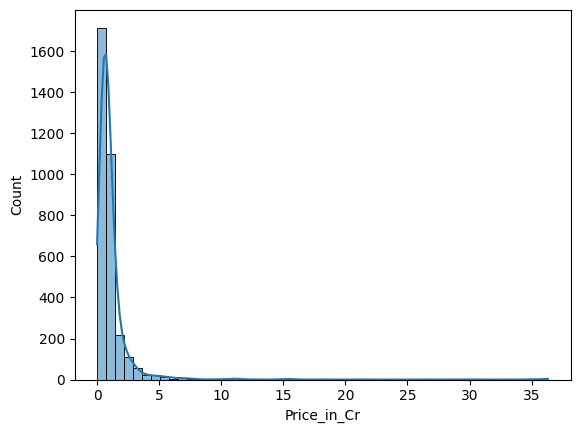

In [54]:
sns.histplot(df['Price_in_Cr'],kde=True,bins=50)

In [55]:
px.box(df,x='Price_in_Cr',width=1000,height=500)

## Is commercial 
(1) Only 11% of the flats are commercial 

In [56]:
df['is_commercial'].isnull().sum()

0

In [57]:
px.pie(df['is_commercial'].value_counts(),values=df['is_commercial'].value_counts(),
names=df['is_commercial'].value_counts().index,hole=0.2,width=600,height=600).show()

## Is Residential 

In [58]:
df['is_residential'].isnull().sum()

0

In [59]:
px.pie(df['is_residential'].value_counts(),values=df['is_residential'].value_counts(),
names=df['is_residential'].value_counts().index,hole=0.2,width=600,height=600).show()

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



In [61]:
df = pd.read_csv('feature_engineered.csv')

# Floor Area

In [62]:
df['Floor_area'].describe()

count      3224.000000
mean       1416.959677
std        2124.519985
min          84.000000
25%        1050.000000
50%        1301.500000
75%        1554.000000
max      108000.000000
Name: Floor_area, dtype: float64

In [63]:
df = df[df['Floor_area'] != 108000.000000]

In [64]:
df = df[~df['Title'].str.contains('land',case=False,na=False)]

In [65]:
df = df[df['Floor_area'] != 14528.0]

In [66]:
df.drop_duplicates(inplace=True)

In [67]:
df.shape

(2443, 14)

In [68]:
px.box(df, x='Floor_area')

4.905823672560043

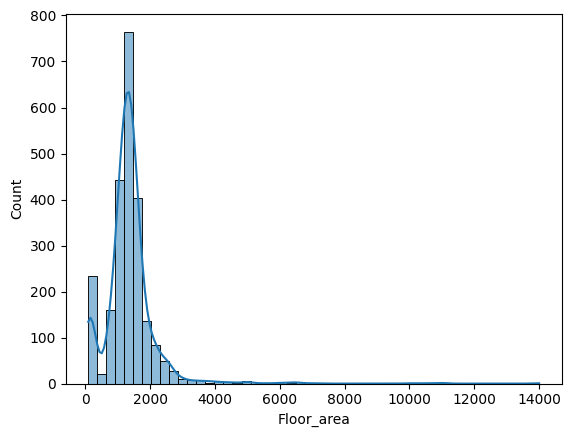

In [69]:
sns.histplot(df['Floor_area'],kde=True,bins=50)
df['Floor_area'].skew()

-1.7672037369753892

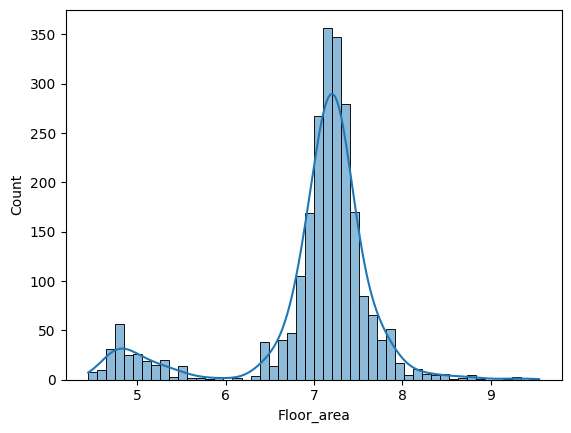

In [70]:
sns.histplot(np.log1p(df['Floor_area']),kde=True,bins=50)
np.log1p(df['Floor_area']).skew()

In [71]:
q1 = df['Floor_area'].quantile(0.25)
q3 = df['Floor_area'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
print(lower_bound)
print(upper_bound)



300.0
2300.0


In [72]:
df[(df['Floor_area'] < lower_bound) | (df['Floor_area'] > upper_bound)].shape

(364, 14)

In [73]:
df[df['Floor_area'] > 3000][['location_area','Price_in_Cr']]

,location_area,Price_in_Cr
21,gulshan,7.80
22,kathalbagan,11.00
127,uttara,3.90
140,bashundhara,5.40
156,uttara,4.50
351,uttara,5.70
425,uttara,4.40
436,bashundhara,3.41
468,dhanmondi,2.90
526,motijheel,5.78


# Price in Cr

In [74]:
df['Price_in_Cr'].describe()

count    2443.000000
mean        1.026521
std         1.554044
min         0.000000
25%         0.500000
50%         0.700000
75%         1.070000
max        35.000000
Name: Price_in_Cr, dtype: float64

In [75]:
px.box(df, x='Price_in_Cr')

In [76]:
df = df[df['Price_in_Cr'] != 0]

In [77]:
df = df[df['Price_in_Cr'] != 0.010000]

In [78]:
df = df[~(df['Price_in_Cr'] < 0.1)]

In [79]:
df[df['Price_in_Cr'] > 15]

,Title,Bedrooms,Bathrooms,Floor_no,Occupancy_status,Floor_area,City,Location,location_area,Price_in_Cr,is_commercial,is_residential,Price_per_sqft,floor_level
622,6200 Sq Ft Commercial Space With Quality Fitti...,NaN,NaN,3.0,vacant,6200.0,dhaka,"North Ibrahimpur, Ibrahimpur",ibrahimpur,15.50,1.0,0.0,25000.00,low
1410,11003 Square Feet Commercial Space Is Ready Fo...,NaN,NaN,5.0,vacant,11003.0,dhaka,"Block I, Bashundhara R-A",bashundhara,15.40,1.0,0.0,13996.18,medium
1423,Commercial Area Of 11003 Sq Ft Is Up For Sale ...,NaN,NaN,11.0,vacant,11003.0,dhaka,"Block I, Bashundhara R-A",bashundhara,15.40,1.0,0.0,13996.18,high
1487,See This 4686 Sq Ft Vacant Commercial Space Up...,NaN,NaN,1.0,vacant,4686.0,dhaka,"Motijheel Road, Motijheel",motijheel,21.09,1.0,0.0,45006.40,low
1739,14000 Sq Ft A Fully Fitted Elegant Office Is A...,NaN,NaN,6.0,vacant,14000.0,chattogram,"28 No. Pathantooly Ward, Double Mooring",double mooring,35.00,1.0,0.0,25000.00,medium
2767,This 10000 Sq Ft Commercial Space Is Up For Sa...,NaN,NaN,10.0,vacant,10000.0,chattogram,"CDA Avenue, East Nasirabad",east nasirabad,30.00,1.0,0.0,30000.00,high
3240,6500 Square Feet Commercial Space Is Available...,NaN,NaN,3.0,vacant,6500.0,gazipur,"Shimultoly, Gazipur Sadar Upazila",gazipur sadar upazila,18.20,1.0,0.0,28000.00,low


In [80]:
df = df[df['is_commercial'] == 0]

In [81]:
df.shape

(2113, 14)

In [82]:
df = df[df['Price_in_Cr'] != 0.13]

In [83]:
df = df[~(df['Price_in_Cr'] > 8)]

## Price_per_sqft

2.6395557006007606

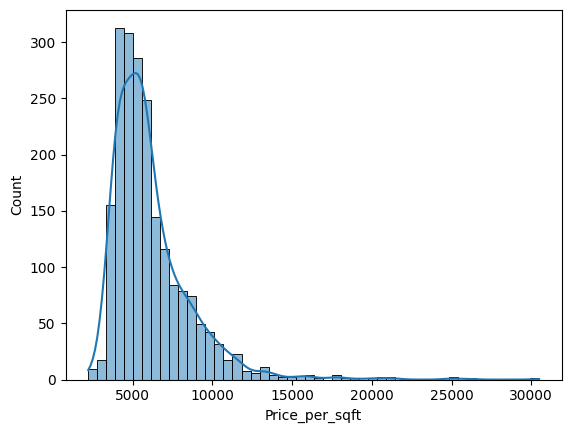

In [84]:
sns.histplot(df['Price_per_sqft'],kde=True,bins=50)
df['Price_per_sqft'].skew()

0.7694354984647982

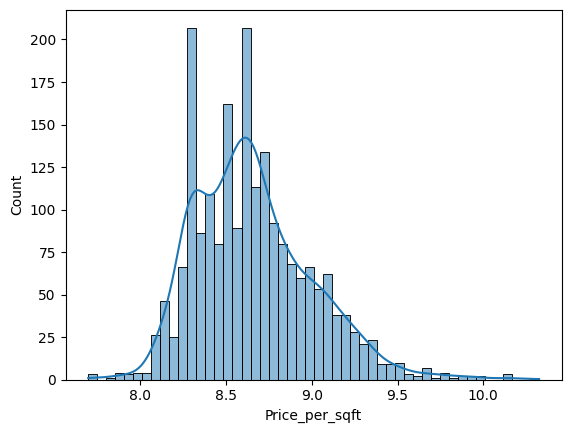

In [85]:
sns.histplot(np.log1p(df['Price_per_sqft']),kde=True,bins=50)
np.log1p(df['Price_per_sqft']).skew()

In [86]:
df['Price_per_sqft'].describe()

count     2054.000000
mean      6130.668939
std       2530.324105
min       2200.000000
25%       4480.690000
50%       5515.150000
75%       6972.817500
max      30496.450000
Name: Price_per_sqft, dtype: float64

In [87]:
px.box(df, x='Price_per_sqft')

In [88]:
df = df[df['Price_per_sqft'] != 30496.45]

In [89]:
df[df.isna().any(axis=1)]

,Title,Bedrooms,Bathrooms,Floor_no,Occupancy_status,Floor_area,City,Location,location_area,Price_in_Cr,is_commercial,is_residential,Price_per_sqft,floor_level
40,1504 Sq Ft Flat Is For Sale In The Thriving Ar...,3.0,3.0,1.0,vacant,1504.0,dhaka,Keraniganj,NaN,0.71,0.0,1.0,4720.74,low
609,1254 Sq Ft Flat For Sale In Kalachandpur,3.0,3.0,6.0,vacant,1254.0,dhaka,NaN,NaN,0.83,0.0,1.0,6618.82,medium
700,A Nicely Constructed Apartment Of 1175 Sq Ft I...,3.0,3.0,NaN,vacant,1175.0,dhaka,"Outer Circular Road, Shiddheswari",shiddheswari,1.00,0.0,1.0,8510.64,NaN
918,"950 Sq Ft Flat For Sale In East Rampura, Tv Road",3.0,2.0,NaN,vacant,950.0,dhaka,"East Rampura, Rampura",rampura,0.70,0.0,1.0,7368.42,NaN
972,A Fine Flat Is Now For Sale Which Is In Agarga...,3.0,3.0,5.0,vacant,1400.0,dhaka,Agargaon,NaN,0.65,0.0,1.0,4642.86,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3182,700 Sq Ft Apartment Is Available For Sale In T...,2.0,1.0,NaN,vacant,700.0,gazipur,"Tongi, Gazipur Sadar Upazila",gazipur sadar upazila,0.22,0.0,1.0,3142.86,NaN
3258,Well Developed Flat Is Up For Sale In Chandara...,3.0,3.0,NaN,vacant,1500.0,gazipur,"Chandara, Gazipur Sadar Upazila",gazipur sadar upazila,0.60,0.0,1.0,4000.00,NaN
3259,Visit This Apartment For Sale In Bonomala Near...,NaN,NaN,NaN,NaN,NaN,gazipur,"Tongi, Gazipur Sadar Upazila",gazipur sadar upazila,0.40,0.0,1.0,NaN,NaN
3273,"Buy This Flat Of 720 Sq Ft Apartment In Tongi,...",2.0,1.0,NaN,vacant,720.0,gazipur,"Tongi, Gazipur Sadar Upazila",gazipur sadar upazila,0.26,0.0,1.0,3611.11,NaN


In [90]:
df['Price_per_sqft'] = ((df['Price_in_Cr']*10000000)/df['Floor_area']).round(2)

In [91]:
df.isnull().sum()

Title                0
Bedrooms            59
Bathrooms           59
Floor_no            62
Occupancy_status    56
Floor_area          56
City                 0
Location             1
location_area       14
Price_in_Cr          0
is_commercial        0
is_residential       0
Price_per_sqft      56
floor_level         62
dtype: int64

In [92]:
df.drop(columns=['Floor_no','Occupancy_status','Location','is_commercial','is_residential'],inplace=True)

In [93]:
df.columns

Index(['Title', 'Bedrooms', 'Bathrooms', 'Floor_area', 'City', 'location_area',
       'Price_in_Cr', 'Price_per_sqft', 'floor_level'],
      dtype='object')

In [94]:
df.to_csv('Outlier & partial missing.csv',index=False)

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')



In [96]:
df = pd.read_csv('Outlier & partial missing.csv')

In [97]:
df.head()

,Title,Bedrooms,Bathrooms,Floor_area,City,location_area,Price_in_Cr,Price_per_sqft,floor_level
0,We Are Offering You A Very Spacious 1960 Sq Ft...,3.0,4.0,1960.0,dhaka,gulshan,3.90,19897.96,low
1,Valuable 1705 Square Feet Apartment Is Ready T...,3.0,3.0,1705.0,dhaka,kalabagan,1.69,9912.02,low
2,1370 square feet apartment is ready to sale in...,3.0,3.0,1370.0,dhaka,dhanmondi,1.25,9124.09,medium
3,2125 Square Feet Apartment For Sale In Bashund...,3.0,3.0,2125.0,dhaka,bashundhara,2.00,9411.76,medium
4,Buy This 2687 Square Feet Flat In The Nice Are...,3.0,3.0,2687.0,dhaka,banani,4.75,17677.71,medium


# Univariate Analysis

## Bedrooms

In [98]:
fig = px.pie(data_frame=df['Bedrooms'].value_counts(),names=df['Bedrooms'].value_counts().index,
       values=df['Bedrooms'].value_counts(),width=500,height=500,hole=0.2)

fig.update_layout(title_text='Bedrooms',title_x=0.5)
fig.show()

Bedroom is not an important column as there is not much of a variety  
78% Houses have 3 bedrooms 

## Bathrooms

In [99]:
fig = px.bar(y=df['Bathrooms'].value_counts(),width=800,height=400)

fig.update_layout(title_text='Bathrooms',title_x=0.5,xaxis_title='Bathrooms',yaxis_title='Count')
fig.show()

In [100]:
fig = px.pie(data_frame=df['Bathrooms'].value_counts(),names=df['Bathrooms'].value_counts().index,
       values=df['Bathrooms'].value_counts(),width=500,height=500,hole=0.2)

fig.update_layout(title_text='Bathrooms',title_x=0.5)
fig.show()

63% of the Houses has 3 Bedrooms 
And the majority belongs to 3,2 & 4

## Floor_area

In [101]:
df['Floor_area'].describe()

count    2053.000000
mean     1415.392596
std       480.292240
min       250.000000
25%      1150.000000
50%      1350.000000
75%      1570.000000
max      6509.000000
Name: Floor_area, dtype: float64

Skewness: 2.616944869062649
Kurtosis: 16.631369328628168


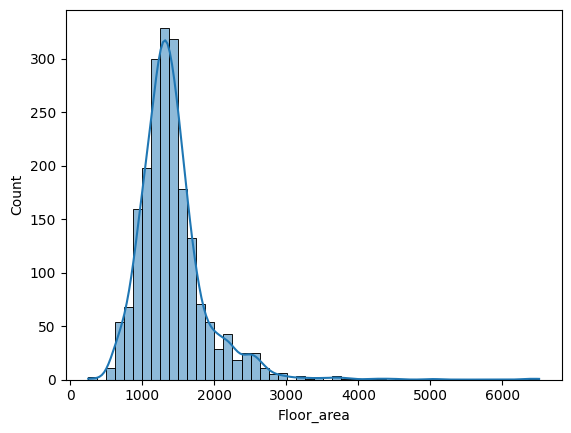

In [102]:
sns.histplot(df['Floor_area'],kde=True,bins=50)
print(f'Skewness: {df["Floor_area"].skew()}')
print(f'Kurtosis: {df["Floor_area"].kurt()}')


Skewness: 0.23303268949949954
Kurtosis: 2.0786125581770025


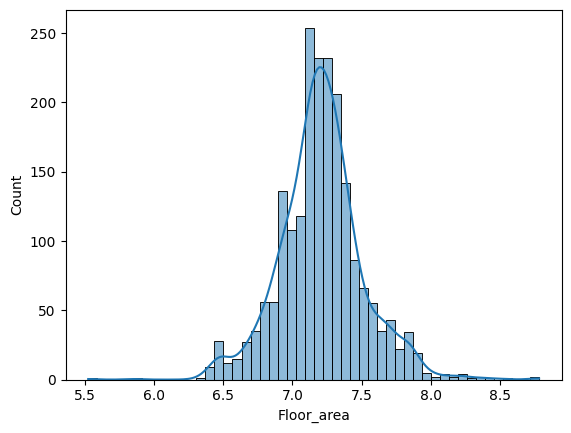

In [103]:
sns.histplot(np.log1p(df['Floor_area']),kde=True,bins=50)
print(f'Skewness: {np.log1p(df["Floor_area"]).skew()}')
print(f'Kurtosis: {np.log1p(df["Floor_area"]).kurt()}')

In [104]:
px.box(df,x='Floor_area',width=800,height=400)

In [105]:
px.box(x=np.log1p(df['Price_in_Cr']),width=800,height=400)

Floor_area is right skewed and the kurtosis value is greater than 3 so even after cleaning the outliers there are some genuine extreme values. 
We can use log transformation to reduce the Skewness here  
The mean value is 1419

 ## City

In [106]:
fig = px.pie(data_frame=df['City'].value_counts(),names=df['City'].value_counts().index,
       values=df['City'].value_counts(),width=500,height=500,hole=0.2)

fig.update_layout(title_text='City',title_x=0.5)
fig.show()

 Most of the Houses are Based on Dhaka and Chattogram

## Location Area

In [107]:
df['location_area'].value_counts().head(10)

location_area
mirpur                   396
gazipur sadar upazila    131
bashundhara              111
double mooring           109
bakalia                  106
bayazid                   93
uttara                    73
khulshi                   72
north pahartali ward      66
bagmoniram ward           56
Name: count, dtype: int64

In [108]:
fig = px.bar(x=df['location_area'].value_counts().head(10).index,y=df['location_area'].value_counts().head(10),width=800,height=400)
fig.update_layout(title_text='location_area',title_x=0.5,xaxis_title='location_area',yaxis_title='Count')
fig.show()

Mirpur Has the highest Number of Houses

## Price_in_Cr

In [109]:
df['Price_in_Cr'].describe()

count    2109.000000
mean        0.931859
std         0.741166
min         0.180000
25%         0.530000
50%         0.710000
75%         1.080000
max         7.800000
Name: Price_in_Cr, dtype: float64

Skewness: 3.670082276330498
Kurtosis: 19.292766563749513


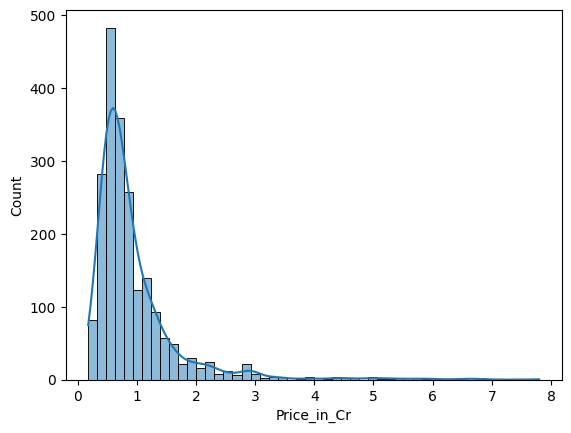

In [110]:
sns.histplot(df['Price_in_Cr'],kde=True,bins=50)
print(f'Skewness: {df["Price_in_Cr"].skew()}')
print(f'Kurtosis: {df["Price_in_Cr"].kurt()}')

Skewness: 1.7792482767994842
Kurtosis: 4.383352143050519


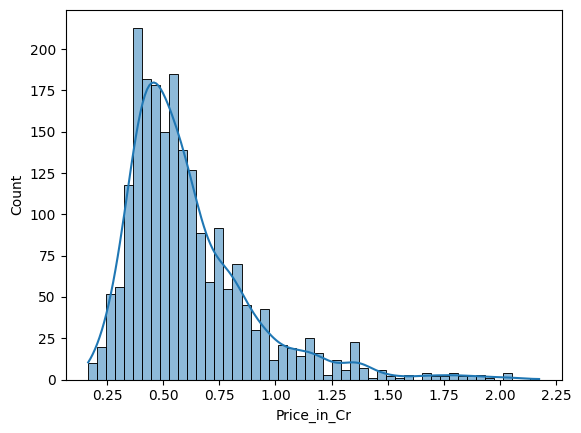

In [111]:
sns.histplot(np.log1p(df['Price_in_Cr']),kde=True,bins=50)
print(f'Skewness: {np.log1p(df["Price_in_Cr"]).skew()}')
print(f'Kurtosis: {np.log1p(df["Price_in_Cr"]).kurt()}')

In [112]:
px.box(x=df['Price_in_Cr'],width=800,height=400)

In [113]:
px.box(x=np.log1p(df['Price_in_Cr']),width=800,height=400)


Same as the Floor Area column , we can use log transformation to redeuce the outliers and skewness  
The Average price is 0.93 Cr

## Price_per_sqft 

Skewness: 2.3763501280667287
Kurtosis: 10.006190584434252


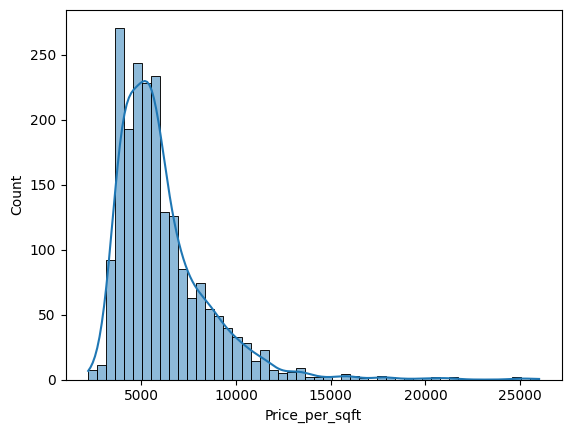

In [114]:
sns.histplot(df['Price_per_sqft'], kde=True, bins=50)
print(f"Skewness: {df['Price_per_sqft'].skew()}")
print(f"Kurtosis: {df['Price_per_sqft'].kurt()}")

Skewness: 0.7323555014961868
Kurtosis: 0.8336834308443639


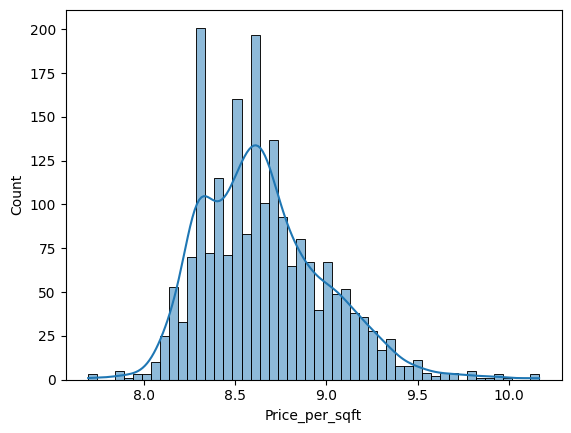

In [115]:
sns.histplot(np.log1p(df['Price_per_sqft']),kde=True,bins=50)
print(f"Skewness: {np.log1p(df['Price_per_sqft']).skew()}")
print(f"Kurtosis: {np.log1p(df['Price_per_sqft']).kurt()}")

In [116]:
px.box(x=df['Price_per_sqft'],width=800,height=400)

In [117]:
px.box(x=np.log1p(df['Price_per_sqft']),width=800,height=400)

Log transformation is needed for converging to normal distribution and outlier removal

## floor_level

In [118]:
fig = px.pie(data_frame=df['floor_level'].value_counts(),names=df['floor_level'].value_counts().index,
             values=df['floor_level'].value_counts(),width=500,height=500,hole=0.2)

fig.update_layout(title_text='floor_level',title_x=0.5)

55% of houses are on medium level 

# **(4) Feature Engineering-2**

In [119]:
df['Is_in_Dhaka'] = df['City'].apply(lambda x : 'yes' if x == 'dhaka' else 'no')

In [120]:
fig = px.pie(data_frame=df['Is_in_Dhaka'].value_counts(),names=df['Is_in_Dhaka'].value_counts().index,
             values=df['Is_in_Dhaka'].value_counts(),width=500,height=500,hole=0.2)

fig.update_layout(title_text='Is_in_Dhaka',title_x=0.5)

46% houses are in dhaka 

## (b) BI & Multivariate Analysis

## Bathrooms , Bedrooms & Price 

In [121]:

fig = px.imshow(pd.crosstab(df['Bedrooms'],df['Bathrooms']),text_auto=True,width=500,height=500,color_continuous_scale='Hot')
fig.update_layout(title_text='Bedrooms vs Bathrooms',title_x=0.5)
fig.show()

The combination of 3 bedrooms and 3 bathrooms are the highest.  
2nd highest combination is 2 bedrooms and 2 bathrooms

In [122]:
fig = px.imshow(pd.pivot_table(df,index='Bedrooms',columns='Bathrooms',values='Price_in_Cr',aggfunc='mean'),
          text_auto=True,width=600,height=600,color_continuous_scale='Inferno')
fig.update_layout(title_text='Bedrooms vs Bathrooms & Price',title_x=0.5)
fig.show()

The Highest Average Price is 4.24 Cr for 6 Bedrooms with 4 Bathrooms  
The Lowest Average Price is 0.2 Cr for 3 Bedrooms with 1 Bathrooms 

## Bedrooms vs City

In [123]:
fig = px.imshow(pd.crosstab(df['City'],df['Bedrooms']),text_auto=True,width=500,height=500,color_continuous_scale='Inferno')
fig.update_layout(title_text='City vs Bedrooms',title_x=0.5)
fig.show()

Chattogram and Dhaka has the highest number houses with 3 Bedrooms with equal number 690 

In [124]:
fig = px.imshow(pd.pivot_table(df,index='City',columns='Bedrooms',values='Price_in_Cr',aggfunc='mean'),
          text_auto=True,width=600,height=600,color_continuous_scale='Inferno')
fig.update_layout(title_text='City vs Bedrooms & Price',title_x=0.5)
fig.show()

Average price of Houses with 5 and 6 Bedrooms are higher in Dhaka.  
The only house with 7 bedrooms has a lower price than 5 & 6 bedrooms , which is also in dhaka! This might be an outlier , so let's remove it 

In [125]:
df = df[~(df['Bedrooms'] == 7)]

In [126]:
df.columns

Index(['Title', 'Bedrooms', 'Bathrooms', 'Floor_area', 'City', 'location_area',
       'Price_in_Cr', 'Price_per_sqft', 'floor_level', 'Is_in_Dhaka'],
      dtype='object')

## Floor Area

Text(0.5, 1.0, 'Bedrooms vs Floor_area')

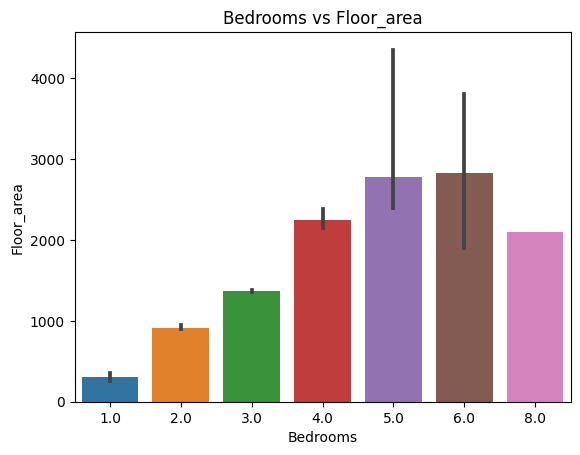

In [127]:
sns.barplot(x=df['Bedrooms'],y=df['Floor_area'],estimator=np.median)
plt.title('Bedrooms vs Floor_area')

In [128]:
df.drop(index=[713,186],inplace=True)

Text(0.5, 1.0, 'Bedrooms vs Floor_area')

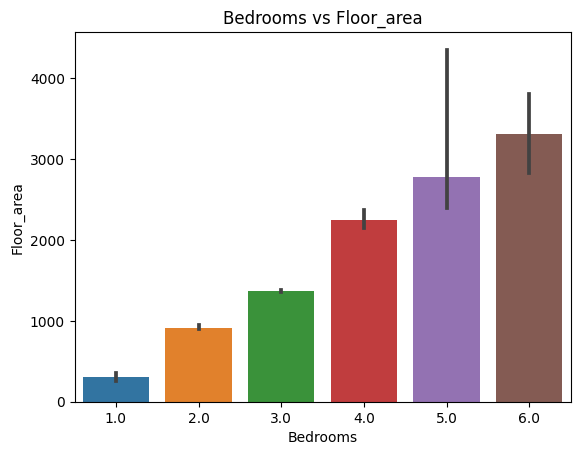

In [129]:
sns.barplot(x=df['Bedrooms'],y=df['Floor_area'],estimator=np.median)
plt.title('Bedrooms vs Floor_area')

Text(0.5, 1.0, 'Bathrooms vs Floor_area')

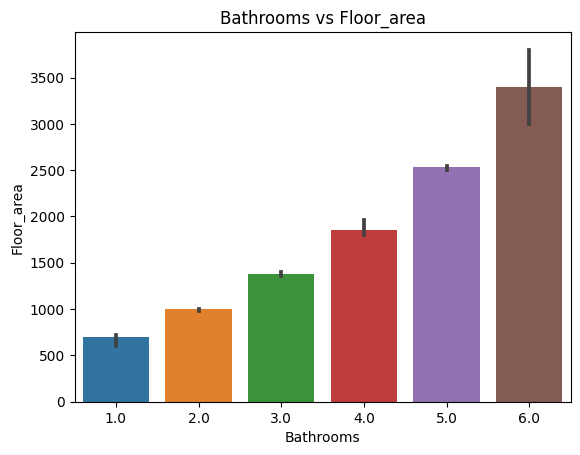

In [130]:
sns.barplot(x=df['Bathrooms'],y=df['Floor_area'],estimator=np.median)
plt.title('Bathrooms vs Floor_area')

Text(0.5, 1.0, 'City vs Floor_area')

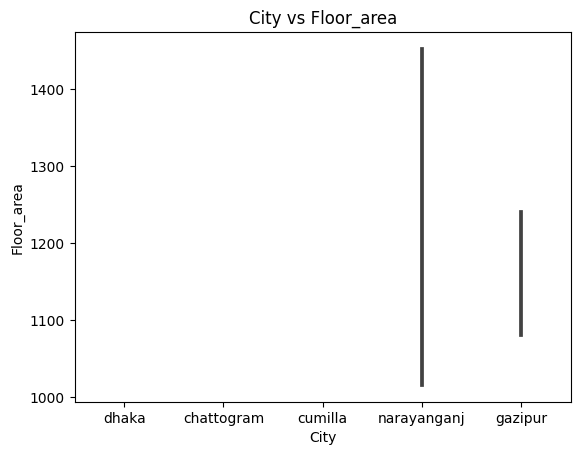

In [131]:
sns.barplot(x=df['City'],y=df['Floor_area'],estimator=np.median)
plt.title('City vs Floor_area')

Chattogram has the highest of Median floor area available  
Narayanganj has the lowest of median floor area available

Text(0.5, 1.0, 'floor_level vs Floor_area')

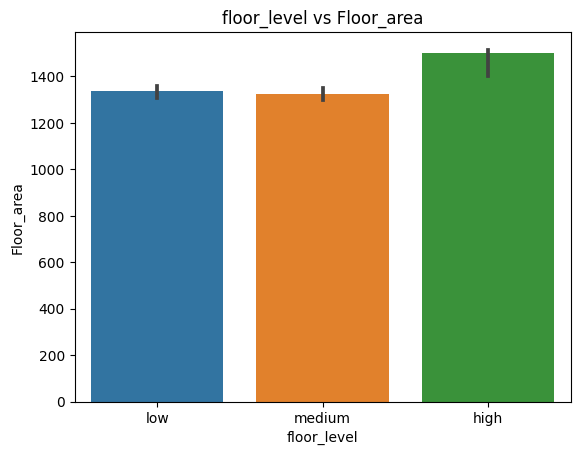

In [132]:
sns.barplot(x=df['floor_level'],y=df['Floor_area'],estimator=np.median)
plt.title('floor_level vs Floor_area')

High Rise Houses has higher median Floor area

In [133]:
fig = px.imshow(pd.crosstab(index=df['Bedrooms'],columns=df['location_area']),
        width=1000,height=500,color_continuous_scale='Inferno')
fig.update_layout(title_text='Bedrooms vs location_area',title_x=0.5)
fig.show()

Mirpur locality has the highest number of houses with 2 & 3 Bedrooms.

(1) Chattogram has the highest number of high rising floors with highest floor_area  
(2) Gazipur has the lowest number of low rising floors with lowest floor_area

In [134]:
fig = px.imshow(pd.crosstab(df['Bedrooms'],df['floor_level']),text_auto=True,width=800,height=400,color_continuous_scale='Inferno')
fig.update_layout(title_text='Bedrooms vs floor_level',title_x=0.5)
fig.show()

Medium Rising floors has the highest number of 3 Bedrooms flat 

In [135]:
fig = px.imshow(pd.pivot_table(data=df,index=df['Bedrooms'],columns=df['floor_level'],values='Price_in_Cr',aggfunc='mean'),
          text_auto=True,width=800,height=400,color_continuous_scale='Inferno')
fig.update_layout(title_text='Bedrooms vs floor_level & Price',title_x=0.5)

Highest mean price is for Medium rising 6 Bedrooms houses  
2nd highest mean price is for High rising 5 Bedrooms houses

## Target Column

Text(0.5, 1.0, 'Bathrooms vs Price')

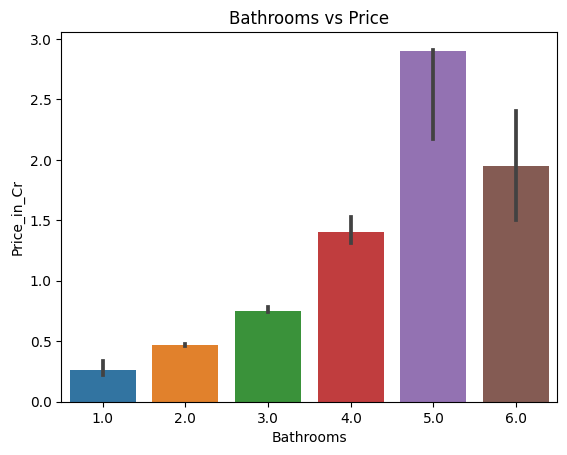

In [136]:
sns.barplot(y=df['Price_in_Cr'],x=df['Bathrooms'],estimator=np.median)
plt.title('Bathrooms vs Price')

Prices were increasing with Bathrooms but suddenly it droped at 6 bathroom , weird.

In [137]:
df[df['Bathrooms'] == 6]

,Title,Bedrooms,Bathrooms,Floor_area,City,location_area,Price_in_Cr,Price_per_sqft,floor_level,Is_in_Dhaka
1055,3000 Sq Ft Apartment Is Ready For Sale At 18 N...,4.0,6.0,3000.0,chattogram,bakalia,1.5,5000.00,medium,no
1631,3800 Sq Ft Apartment Is Now Ready To Sell In 1...,6.0,6.0,3800.0,chattogram,north kattali ward,2.4,6315.79,low,no


There are lot's of Houses with Bedrooms less than Bathrooms

In [138]:
fig =px.scatter(y=df['Price_in_Cr'],x=df['Floor_area'],width=800,height=400,trendline='lowess')
fig.update_layout(title_text='Floor_area vs Price',title_x=0.5,xaxis_title='Floor_area',yaxis_title='Price')
fig.show()

Prices are increasing with floor_area which is normal  
The relationship is linear

In [139]:
fig = px.scatter(y=df['Price_in_Cr'],x=df['Floor_area'],color=df['City'],width=800,height=400,trendline='lowess')
fig.update_layout(title_text='Floor_area vs Price vs City',title_x=0.5,xaxis_title='Floor_area',yaxis_title='Price')
fig.show()

Prices are higher in Dhaka in floor_area compare to other region

In [140]:
fig = px.scatter(y=df['Price_in_Cr'],x=df['Floor_area'],color=df['floor_level'],width=800,height=400,trendline='lowess')
fig.update_layout(title_text='Floor_area vs Price vs floor_level',title_x=0.5,xaxis_title='Floor_area',yaxis_title='Price')
fig.show()

In [141]:
df[((df['floor_level'] == 'high') & (df['Floor_area'] >4000))]

,Title,Bedrooms,Bathrooms,Floor_area,City,location_area,Price_in_Cr,Price_per_sqft,floor_level,Is_in_Dhaka
103,5040 Sq. Ft Apartment Which Is Up For Sale At ...,4.0,4.0,5040.0,dhaka,bashundhara,5.4,10714.29,high,yes
138,4350 Sq Ft Modern And Spacious Flat For Sale I...,5.0,5.0,4350.0,dhaka,uttara,5.7,13103.45,high,yes
1143,A Nicely Constructed Apartment Of 6509 Sq Ft I...,4.0,5.0,6509.0,chattogram,bagmoniram ward,6.5,9986.17,high,no


The Floor_area values seems like outliers with values greater than 4000 sqft. I don't know what to do with those!  
let's keep them 

In [142]:
df = df[~((df['Is_in_Dhaka'] == 'no') & (df['Floor_area'] > 4000))]

In chattogram bhaghmonirhat , there are 2 flats with extreme high value of Floor_area  
greater than 4500 sqft , let's remove those

In [143]:
fig = px.scatter(y=df['Price_in_Cr'],x=df['Floor_area'],color=df['Is_in_Dhaka'],width=800,height=400,trendline='lowess')
fig.update_layout(title_text='Floor_area vs Price vs Is_in_Dhaka',title_x=0.5,xaxis_title='Floor_area',yaxis_title='Price')
fig.show()

In [144]:
fig =px.scatter(y=df['Price_in_Cr'],x=df['Price_per_sqft'],width=800,height=400,trendline='lowess')
fig.update_layout(title_text='Price_per_sqft vs Price',title_x=0.5,xaxis_title='Price_per_sqft',yaxis_title='Price')
fig.show()

The relationship between Price and Price per sqft is linear which is normal to assume

In [145]:
df = df[~((df['City'].isin(['cumilla'])) & (df['Price_per_sqft'] > 6000))]

Found an outlier value for cumilla with price per sqft is at 10k , which is a business space. Removing that row

In [146]:
df = df[~((df['City'].isin(['gazipur'])) & (df['Price_per_sqft'] > 6000))]

Found an outlier value for gazipur with price per sqft is at 12.5k , which is a warehouse. Removing that row

In [147]:
fig =px.scatter(y=df['Price_in_Cr'],x=df['Price_per_sqft'],color=df['City'],width=800,height=400,trendline='lowess')
fig.update_layout(title_text='Price_per_sqft vs Price vs City',title_x=0.5,xaxis_title='Price_per_sqft',yaxis_title='Price')
fig.show()

In Dhaka , the spread between price and price per sqft is higher  
The spread in chattogram is more stable compare to other region  
cumilla and gazipur have a non linear trend

In [148]:
fig = px.scatter(y=df['Price_in_Cr'],x=df['Price_per_sqft'],color=df['floor_level'],width=800,height=400,trendline='lowess')
fig.update_layout(title_text = 'Price_per_sqft vs Price vs floor_level',title_x=0.5,xaxis_title='Price_per_sqft',yaxis_title='Price')
fig.show()

The price vs Price per sqft relation is non-linear for High Rising floors

In [149]:
df[((df['floor_level'].isin(['medium'])) & (df['Price_per_sqft'] > 24000))]

,Title,Bedrooms,Bathrooms,Floor_area,City,location_area,Price_in_Cr,Price_per_sqft,floor_level,Is_in_Dhaka
752,2700 Square Feet Apartment Is Ready For Sale I...,3.0,3.0,2700.0,dhaka,banani dohs,6.75,25000.0,medium,yes
753,2700 Square Feet Great Apartment For Sale In B...,3.0,3.0,2700.0,dhaka,banani dohs,6.75,25000.0,medium,yes


In [150]:
df[df['location_area'] == 'banani dohs']

,Title,Bedrooms,Bathrooms,Floor_area,City,location_area,Price_in_Cr,Price_per_sqft,floor_level,Is_in_Dhaka
228,Notable 2500 Square Feet Apartment For Sale In...,3.0,3.0,2500.0,dhaka,banani dohs,6.50,26000.0,low,yes
752,2700 Square Feet Apartment Is Ready For Sale I...,3.0,3.0,2700.0,dhaka,banani dohs,6.75,25000.0,medium,yes
753,2700 Square Feet Great Apartment For Sale In B...,3.0,3.0,2700.0,dhaka,banani dohs,6.75,25000.0,medium,yes


In [151]:
fig = px.scatter(y=df['Price_in_Cr'],x=df['Price_per_sqft'],color=df['Is_in_Dhaka'],width=800,height=400,trendline='lowess')
fig.update_layout(title_text = 'Price_per_sqft vs Price vs Is_in_Dhaka',title_x=0.5,xaxis_title='Price_per_sqft',yaxis_title='Price')
fig.show()

<Axes: xlabel='City', ylabel='Price_in_Cr'>

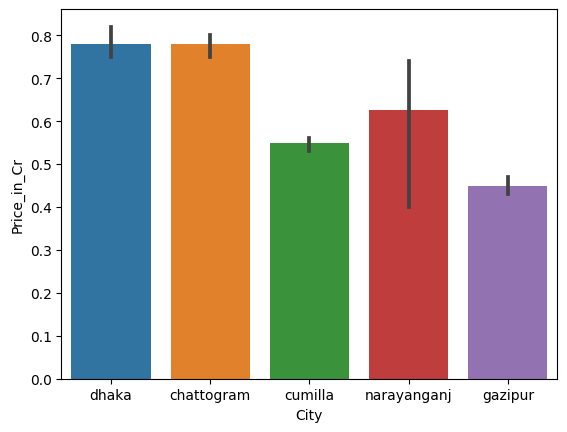

In [152]:
sns.barplot(data=df,y='Price_in_Cr',x='City',estimator=np.median)

Dhaka and Chattogram has simillar median price in Cr around 80 lacs  
Gazipur has the lowest median price in Cr around 40 lacs 

<Axes: xlabel='Is_in_Dhaka', ylabel='Price_in_Cr'>

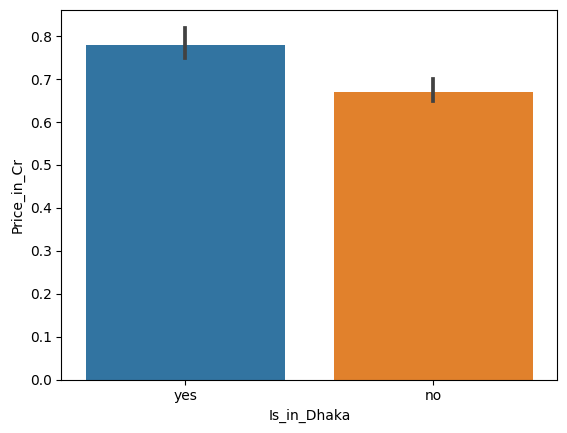

In [153]:
sns.barplot(data=df,y='Price_in_Cr',x='Is_in_Dhaka',estimator=np.median)

Dhaka has higher median price than other region combined

# **(5) Full EDA Analysis**



### 🏠 **General Observations**
- **Bedrooms**: Not a strong differentiator — **78%** of houses have **3 bedrooms**, and **63%** have **3 bathrooms**. Most combinations are **3 beds & 3 baths**, followed by **2 beds & 2 baths**.
- **Floors**: Majority of houses are on **2, 3, or 4 floors**.
- **Regions**: Most houses are located in **Dhaka** and **Chattogram**, with **Mirpur** having the highest concentration.



### 📊 **Numerical Features**
#### **Floor Area**
- **Right-skewed** distribution with **kurtosis > 3**, indicating presence of genuine extreme values.
- **Mean floor area**: ~1419 sqft.
- **Log transformation** recommended to reduce skewness and manage outliers.
- **Outliers**:
  - Values > 4000 sqft are potential outliers but retained.
  - **Bhaghmonirhat (Chattogram)** has 2 extreme values > 4500 sqft — removed.

#### **Price**
- **Average price**: ~0.93 Cr.
- **Log transformation** suggested for normalization and outlier handling.
- **Highest average price**: 4.24 Cr for **6 beds & 4 baths**.
- **Lowest average price**: 0.2 Cr for **3 beds & 1 bath**.
- **Price increases with floor area** — **linear relationship**.

#### **Price per Sqft**
- **Highly correlated** with target price.
- **Outliers**:
  - **Cumilla**: 10k/sqft (business space) — removed.
  - **Gazipur**: 12.5k/sqft (warehouse) — removed.
- **Linear relationship** with price overall, but **non-linear** for **high-rise floors**.



### 🏢 **Location-Based Insights**
- **Dhaka & Chattogram**: Highest number of houses with 3 bedrooms (690 each).
- **Dhaka**: Higher median price than other regions combined.
- **Gazipur**: Lowest median price (~40 lacs).
- **Chattogram**: More stable price-per-sqft spread.
- **Cumilla & Gazipur**: Show **non-linear** trends in price vs. price-per-sqft.


### 🏗️ **Building Type Insights**
- **High-rise houses**: Higher median floor area.
- **Medium-rise houses**:
  - Most common for 3-bedroom flats.
  - Highest mean price for 6-bedroom units.
- **Low-rise houses**: Least floor area, especially in Gazipur.


### 🛁 **Bathroom Trends**
- Price generally increases with number of bathrooms, but drops unexpectedly at **6 bathrooms** — possibly an anomaly.
- Some houses have **more bathrooms than bedrooms**, which is unusual.



# **(6) Missing_Value_Imputation (Manual)**

In [154]:
df['Bedrooms'].fillna(df['Bedrooms'].median(),inplace=True)

In [155]:
df['Bathrooms'].fillna(df['Bathrooms'].median(),inplace=True) 

In [156]:
df['floor_level'].fillna(df['floor_level'].mode()[0],inplace=True)


In [157]:
df['Floor_area'].fillna(df['Floor_area'].median(),inplace=True)

In [158]:
df['Price_per_sqft'].fillna(df['Price_per_sqft'].median(),inplace=True)

In [159]:
df['Price_in_Cr'].isnull().sum()

0

In [160]:
df.to_csv('final_data.csv',index=False)

# **(7) Feature Importance Selection**

In [161]:
df = pd.read_csv('final_data.csv')

In [162]:
df = df.drop(['Title'],axis=1)

In [163]:
import category_encoders as ce

In [164]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
df[['City','floor_level','Is_in_Dhaka']] = OrdinalEncoder(handle_unknown='error').fit_transform(df[['City','floor_level','Is_in_Dhaka']])

In [165]:
df[['location_area']] = ce.TargetEncoder().fit_transform(df[['location_area']],df[['Price_in_Cr']])

In [166]:
x = df.drop(['Price_in_Cr'],axis=1)
y = df['Price_in_Cr']

In [167]:
from sklearn.preprocessing import StandardScaler

x_scaled = StandardScaler().fit_transform(x)


## Correlation

In [168]:
px.imshow(df.corr(),text_auto=True,width=800,height=600)

In [169]:
fi_df1 = df.corr()['Price_in_Cr'].to_frame().sort_values(by='Price_in_Cr',ascending=False).reset_index().rename({'index':'Features','Price_in_Cr':'Importance'},axis=1)

In [170]:
fi_df1

,Features,Importance
0,Price_in_Cr,1.000000
1,Price_per_sqft,0.840686
2,Floor_area,0.782827
3,location_area,0.629531
4,Bathrooms,0.537155
5,Bedrooms,0.483258
6,Is_in_Dhaka,0.170526
7,City,0.013084
8,floor_level,-0.047300


In [171]:
fi_df1.tail(3)

,Features,Importance
6,Is_in_Dhaka,0.170526
7,City,0.013084
8,floor_level,-0.047300


## Random Forest Feature Importance

In [172]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100,random_state=0).fit(x_scaled,y)

fi_df2 = pd.DataFrame({'Features':x.columns,'RF_Importance':rf.feature_importances_}).sort_values(by='RF_Importance',ascending=False)
fi_df2

,Features,RF_Importance
5,Price_per_sqft,0.517999
2,Floor_area,0.397119
4,location_area,0.062577
3,City,0.018734
6,floor_level,0.001310
1,Bathrooms,0.000969
7,Is_in_Dhaka,0.000673
0,Bedrooms,0.000617


In [173]:
fi_df2.tail(3)

,Features,RF_Importance
1,Bathrooms,0.000969
7,Is_in_Dhaka,0.000673
0,Bedrooms,0.000617


## Gradient Boosting

In [174]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100,random_state=0).fit(x_scaled,y)

fi_df3 = pd.DataFrame({'Features':x.columns,'GB_Importance':gb.feature_importances_}).sort_values(by='GB_Importance',ascending=False)
fi_df3

,Features,GB_Importance
5,Price_per_sqft,0.481971
2,Floor_area,0.451033
4,location_area,0.048959
3,City,0.017543
1,Bathrooms,0.000289
6,floor_level,0.000111
0,Bedrooms,0.000078
7,Is_in_Dhaka,0.000017


## Lasso

In [175]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1).fit(x_scaled,y)

fi_df4 = pd.DataFrame({'Features':x.columns,'lasso_Importance': lasso.coef_}).sort_values(by='lasso_Importance',ascending=False)
fi_df4

,Features,lasso_Importance
5,Price_per_sqft,0.363980
2,Floor_area,0.273207
0,Bedrooms,0.000000
1,Bathrooms,0.000000
3,City,0.000000
4,location_area,0.000000
6,floor_level,0.000000
7,Is_in_Dhaka,0.000000


## Recursive Feature Elimination
### Backward Subset Selection (mlxtend) 

In [176]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100,random_state=0)
          ,n_features_to_select=x.shape[0]).fit(x_scaled,y)

features = x.columns[rfe.support_]
Importance = rfe.estimator_.feature_importances_

fi_df5 = pd.DataFrame({'Features':features,'RFE_Importance':Importance}).sort_values(by='RFE_Importance',ascending=False)
fi_df5

,Features,RFE_Importance
5,Price_per_sqft,0.517999
2,Floor_area,0.397119
4,location_area,0.062577
3,City,0.018734
6,floor_level,0.001310
1,Bathrooms,0.000969
7,Is_in_Dhaka,0.000673
0,Bedrooms,0.000617


## Permutation Importance

In [177]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size=0.2,random_state=0)

rf = RandomForestRegressor(n_estimators=100,random_state=0)
rf.fit(x_train,y_train)

pi = permutation_importance(estimator=rf,X=x_test,y=y_test,scoring='neg_mean_squared_error',n_repeats=10,random_state=0)

fi_df6 = pd.DataFrame({'Features':x.columns,'PI_Importance':pi.importances_mean}).sort_values(by='PI_Importance',ascending=False)
fi_df6

,Features,PI_Importance
5,Price_per_sqft,0.294284
2,Floor_area,0.203175
4,location_area,0.033946
3,City,0.029886
7,Is_in_Dhaka,0.000450
6,floor_level,0.000375
1,Bathrooms,0.000094
0,Bedrooms,-0.000025


## Shap values

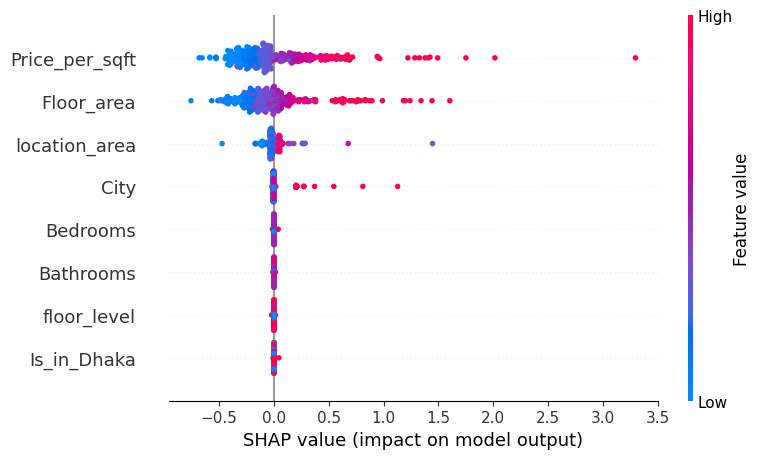

In [178]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer(x_test,check_additivity=False)

shap.summary_plot(shap_values,x_test,feature_names=x.columns)

In [179]:
fi_df7 = pd.DataFrame({'Features':x.columns,'Shap_Importance':np.abs((shap_values.values).mean(axis=0))}).sort_values(by='Shap_Importance',ascending=False)
fi_df7

,Features,Shap_Importance
2,Floor_area,0.022579
3,City,0.017761
5,Price_per_sqft,0.005548
4,location_area,0.003264
7,Is_in_Dhaka,0.000221
6,floor_level,0.000183
0,Bedrooms,0.000082
1,Bathrooms,0.000027


## Merge ALL fi_df

In [180]:
final_df = fi_df1.merge(fi_df2,on='Features').merge(fi_df3,on='Features').merge(fi_df4,on='Features').merge(fi_df5,on='Features').merge(fi_df6,on='Features').merge(fi_df7,on='Features').set_index('Features')

In [181]:
final_df

,Importance,RF_Importance,GB_Importance,lasso_Importance,RFE_Importance,PI_Importance,Shap_Importance
Features,,,,,,,
Price_per_sqft,0.840686,0.517999,0.481971,0.363980,0.517999,0.294284,0.005548
Floor_area,0.782827,0.397119,0.451033,0.273207,0.397119,0.203175,0.022579
location_area,0.629531,0.062577,0.048959,0.000000,0.062577,0.033946,0.003264
Bathrooms,0.537155,0.000969,0.000289,0.000000,0.000969,0.000094,0.000027
Bedrooms,0.483258,0.000617,0.000078,0.000000,0.000617,-0.000025,0.000082
Is_in_Dhaka,0.170526,0.000673,0.000017,0.000000,0.000673,0.000450,0.000221
City,0.013084,0.018734,0.017543,0.000000,0.018734,0.029886,0.017761
floor_level,-0.047300,0.001310,0.000111,0.000000,0.001310,0.000375,0.000183


## Normalization (Dividing each column by it's Column sum)

In [182]:
final_df.divide(final_df.sum(axis=0),axis=1)

,Importance,RF_Importance,GB_Importance,lasso_Importance,RFE_Importance,PI_Importance,Shap_Importance
Features,,,,,,,
Price_per_sqft,0.246552,0.517999,0.481971,0.57123,0.517999,0.523464,0.111712
Floor_area,0.229584,0.397119,0.451033,0.42877,0.397119,0.361402,0.454624
location_area,0.184626,0.062577,0.048959,0.00000,0.062577,0.060383,0.065718
Bathrooms,0.157534,0.000969,0.000289,0.00000,0.000969,0.000168,0.000553
Bedrooms,0.141728,0.000617,0.000078,0.00000,0.000617,-0.000044,0.001644
Is_in_Dhaka,0.050011,0.000673,0.000017,0.00000,0.000673,0.000800,0.004450
City,0.003837,0.018734,0.017543,0.00000,0.018734,0.053159,0.357612
floor_level,-0.013872,0.001310,0.000111,0.00000,0.001310,0.000668,0.003687


In [183]:
final_df.mean(axis=1).sort_values(ascending=False).to_frame('Importance')

,Importance
Features,
Price_per_sqft,0.431781
Floor_area,0.361008
location_area,0.120122
Bathrooms,0.077072
Bedrooms,0.069233
Is_in_Dhaka,0.024652
City,0.016535
floor_level,-0.006287


In [184]:
from sklearn.model_selection import cross_val_score,KFold

cv_original = cross_val_score(estimator=rf,X=x_scaled,y=y,scoring='neg_mean_squared_error',cv=10)
cv_original.mean()

-0.049621824296899465

In [185]:
cv_after = cross_val_score(estimator=rf,X=x.drop(['Is_in_Dhaka','City','floor_level','Bedrooms','Bathrooms'],axis=1),
                           y=y,scoring='neg_mean_squared_error',cv=10)
cv_after.mean()

-0.05666864040068966

# > Main Features are Price_per_sqft , Floor_area and location_area  

# **(8) Baseline Model Selection**

In [186]:
df = pd.read_csv('/kaggle/input/final-data/final_data.csv')
df = df.drop(['Title','Price_per_sqft','Is_in_Dhaka'],axis=1)
df.head()

,Bedrooms,Bathrooms,Floor_area,City,location_area,Price_in_Cr,floor_level
0,3.0,4.0,1960.0,dhaka,gulshan,3.90,low
1,3.0,3.0,1705.0,dhaka,kalabagan,1.69,low
2,3.0,3.0,1370.0,dhaka,dhanmondi,1.25,medium
3,3.0,3.0,2125.0,dhaka,bashundhara,2.00,medium
4,3.0,3.0,2687.0,dhaka,banani,4.75,medium


Removing the Price_per_sqft column because customers shouldn't have a knowledge about the Price_per_sqft either

In [187]:
x = df.drop(['Price_in_Cr'],axis=1)
y = df['Price_in_Cr']

In [188]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [189]:
transformer = ColumnTransformer([
    ('Onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False),['City','Bedrooms','Bathrooms','location_area']),
    ('Ordinal',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),['floor_level']),
    # ('Target_Encoding',TargetEncoder(),['location_area']),
    ('Scaler',StandardScaler(),['Floor_area'])
],remainder='passthrough')

model_pipe = Pipeline([
    ('preprocessing',transformer),
    ('model',LinearRegression())
])



In [190]:
from sklearn.model_selection import cross_val_score,KFold

cv_original = cross_val_score(estimator=model_pipe,X=x_train,y=y_train,scoring='r2',cv=KFold(n_splits=10,shuffle=True,random_state=0))
cv_original.mean()

-1.046629737454208e+23

In [191]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

model_pipe.fit(x_train,y_train)
y_pred = model_pipe.predict(x_test)

MSE = mean_squared_error(y_test,y_pred)
MAE = mean_absolute_error(y_test,y_pred)

print(f'Mean Squared Error: {MSE}')

print(f'Mean Absolute Error: {MAE}')


Mean Squared Error: 2.461641340829193e+22
Mean Absolute Error: 15893342551.485886


In [192]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


model_dict = {
    'linear_reg': LinearRegression(),
    'svr': SVR(),
    'ridge': Ridge(),
    'lasso': Lasso(), 
    'decision_tree': DecisionTreeRegressor(),
    'random_forest': RandomForestRegressor(),
    'extra_trees': ExtraTreesRegressor(),
    'gradient_boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost': XGBRegressor(),
    'lightgbm':LGBMRegressor()
}

## (a) Without Feature Transformation

In [193]:
transformer = ColumnTransformer([
    ('Onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False),['City','Bedrooms','Bathrooms','location_area']),
    ('Ordinal',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),['floor_level']),
    # ('Target_Encoding',TargetEncoder(),['location_area']),
    ('Scaler',StandardScaler(),['Floor_area'])
],remainder='passthrough')


def score(model_name,model):

    output = []
    output.append(model_name)

    model_pipe = Pipeline([
        ('preprocessor',transformer),
        ('regressor',model)
    ])

    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

    # cv = cross_val_score(model_pipe,x_train,y_train,cv=KFold(n_splits=10,shuffle=True,random_state=0),scoring='r2') 
    # output.append(cv.mean())

    model_pipe.fit(x_train,y_train)
    y_pred = model_pipe.predict(x_test)

    R2 = r2_score(y_test,y_pred)
    MSE = mean_squared_error(y_test,y_pred)
    MAE = mean_absolute_error(y_test,y_pred)

    output.append(R2)
    output.append(MSE)
    output.append(MAE)

    return output


model_output  = []
for model_name,model in model_dict.items():
    model_output.append(score(model_name,model))

model_output = pd.DataFrame(model_output,columns=['model_name','r2_score','mse','mae']).sort_values(by='mse',ascending=True)
model_output

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 1681, number of used features: 33
[LightGBM] [Info] Start training from score 0.919131


,model_name,r2_score,mse,mae
9,mlp,8.972258e-01,5.035398e-02,1.360828e-01
6,extra_trees,8.616602e-01,6.777928e-02,1.340210e-01
10,xgboost,8.605542e-01,6.832117e-02,1.426535e-01
2,ridge,8.440192e-01,7.642248e-02,1.715995e-01
7,gradient_boosting,8.423967e-01,7.721742e-02,1.605144e-01
1,svr,8.384137e-01,7.916885e-02,1.490951e-01
5,random_forest,7.958332e-01,1.000311e-01,1.419492e-01
11,lightgbm,7.915725e-01,1.021186e-01,1.658419e-01
4,decision_tree,7.188422e-01,1.377527e-01,1.652117e-01
8,adaboost,6.581536e-01,1.674869e-01,3.124742e-01


## (b) With Feature Transformation (Linear Assumptions)

In [194]:
x_train2,x_test2,y_train2,y_test2 = train_test_split(x,y,test_size=0.2,random_state=0)


floor_area_pipe = Pipeline([
    ('log_transform',PowerTransformer(method='yeo-johnson')),
    ('scalar',StandardScaler())
])

transformer = ColumnTransformer([
    ("floor_area",floor_area_pipe,['Floor_area']),
    ("log_transform",PowerTransformer(method='yeo-johnson'),['Floor_area']),
    ('Onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False),['City','Bedrooms','Bathrooms','location_area']),
    ('Ordinal',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),['floor_level']),
    # ('Target_Encoding',TargetEncoder(random_state=0),['location_area']),
    # ('Scaler',StandardScaler(),['Floor_area'])
],remainder='passthrough')


def score_transformed(model_name,model):

    output = []
    output.append(model_name)

    model_pipe = Pipeline([
        ('preprocessor',transformer),
        ('regressor',model)
    ])

    final_pipe = TransformedTargetRegressor(regressor=model_pipe,func=np.log1p,inverse_func=np.expm1)


    # cv = cross_val_score(final_pipe,x_train2,y_train2,cv=KFold(n_splits=10,shuffle=True,random_state=0),scoring='r2') 
    # output.append(cv.mean())

    final_pipe.fit(x_train2,y_train2)
    y_pred2 = final_pipe.predict(x_test2)

    R2 = r2_score(y_test2,y_pred2)
    MSE = mean_squared_error(y_test2,y_pred2)
    MAE = mean_absolute_error(y_test2,y_pred2)

    output.append(R2)
    output.append(MSE)
    output.append(MAE)

    return output



model_output_transformed  = []
for model_name,model in model_dict.items():
    model_output_transformed.append(score_transformed(model_name,model))

model_output_transformed = pd.DataFrame(model_output_transformed,
                                        columns=['model_name','r2_score','mse','mae']).sort_values(by='mse',ascending=True)
model_output_transformed

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 1681, number of used features: 34
[LightGBM] [Info] Start training from score 0.607124


,model_name,r2_score,mse,mae
9,mlp,0.880799,0.058402,0.145246
1,svr,0.870947,0.063229,0.155830
10,xgboost,0.866515,0.065401,0.139492
2,ridge,0.847247,0.074841,0.161986
6,extra_trees,0.838791,0.078984,0.138420
7,gradient_boosting,0.835055,0.080814,0.156641
11,lightgbm,0.806209,0.094948,0.163231
5,random_forest,0.784523,0.105573,0.143170
8,adaboost,0.721824,0.136292,0.242875
4,decision_tree,0.717795,0.138266,0.164880


# **(9) Hyperparameter tuning (Optuna)**

In [195]:
df = pd.read_csv('/kaggle/input/final-data/final_data.csv')
df = df.drop(['Title','Price_per_sqft','Is_in_Dhaka'],axis=1)
df.head()

,Bedrooms,Bathrooms,Floor_area,City,location_area,Price_in_Cr,floor_level
0,3.0,4.0,1960.0,dhaka,gulshan,3.90,low
1,3.0,3.0,1705.0,dhaka,kalabagan,1.69,low
2,3.0,3.0,1370.0,dhaka,dhanmondi,1.25,medium
3,3.0,3.0,2125.0,dhaka,bashundhara,2.00,medium
4,3.0,3.0,2687.0,dhaka,banani,4.75,medium


In [196]:
x = df.drop('Price_in_Cr',axis=1)
y = df['Price_in_Cr']

## Optuna Gradient Boosting

In [197]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)


floor_area_pipe = Pipeline([
    ('log_transform',PowerTransformer(method='yeo-johnson')),
    ('scalar',StandardScaler())
])

transformer = ColumnTransformer([
    ("floor_area",floor_area_pipe,['Floor_area']),
    ("log_transform",PowerTransformer(method='yeo-johnson'),['Floor_area']),
    ('Onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False),['City','Bedrooms','Bathrooms','location_area']),
    ('Ordinal',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),['floor_level']),
],remainder='passthrough')


def objective(trial,preprocessor):
    regressor_name = trial.suggest_categorical('regressor',['GradientBoostingRegressor'])

    if regressor_name == 'GradientBoostingRegressor':
        n_estimators = trial.suggest_int('model__n_estimators',50,300)
        learning_rate = trial.suggest_float('model__learning_rate',0.05,0.3)
        max_features = trial.suggest_categorical('model__max_features',['sqrt', 'log2'])
        subsample = trial.suggest_float('model__subsample',0.7,1.0)
        max_depth = trial.suggest_int('model__max_depth',3,6)
        min_samples_leaf = trial.suggest_int('model__min_samples_leaf',1,5)
        min_samples_split = trial.suggest_int('model__min_samples_split',2,5)


    model_pipe = Pipeline([
        ('preprocessor',transformer),
        ('model',GradientBoostingRegressor(n_estimators=n_estimators,learning_rate=learning_rate,max_features=max_features,
                                           max_depth=max_depth,min_samples_leaf=min_samples_leaf,
                                           min_samples_split=min_samples_split,subsample=subsample,random_state=0,verbose=0))
                                           ])

    final_pipe = TransformedTargetRegressor(regressor=model_pipe,func=np.log1p,inverse_func=np.expm1)

    trial.set_user_attr('model',final_pipe)

    cv_score = cross_val_score(final_pipe,x_train,y_train,cv=KFold(n_splits=10,shuffle=True,random_state=0),scoring='neg_mean_squared_error')
    return cv_score.mean()


study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=0),pruner=optuna.pruners.HyperbandPruner())
study.optimize(lambda trial : objective(trial,preprocessor=transformer),n_trials=100,n_jobs=-1)
print(f'Best neg score: {study.best_value}')
print(f'Best Params: {study.best_params}')

final_model = study.best_trial.user_attrs['model']
final_model.fit(x_train,y_train)
y_pred = final_model.predict(x_test)

print(f'MSE: {mean_squared_error(y_test,y_pred)}')
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')
print(f'R2: {r2_score(y_test,y_pred)}')

[I 2025-09-27 03:56:48,336] A new study created in memory with name: no-name-2be6d1b9-0005-4d1f-b726-5e36e15298d6
[I 2025-09-27 03:56:58,276] Trial 3 finished with value: -0.07415758189297923 and parameters: {'regressor': 'GradientBoostingRegressor', 'model__n_estimators': 89, 'model__learning_rate': 0.25983387966699106, 'model__max_features': 'sqrt', 'model__subsample': 0.7802360884610525, 'model__max_depth': 6, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}. Best is trial 3 with value: -0.07415758189297923.
[I 2025-09-27 03:56:58,564] Trial 1 finished with value: -0.08703492357954612 and parameters: {'regressor': 'GradientBoostingRegressor', 'model__n_estimators': 114, 'model__learning_rate': 0.24458601311303657, 'model__max_features': 'sqrt', 'model__subsample': 0.956852265926381, 'model__max_depth': 3, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}. Best is trial 3 with value: -0.07415758189297923.
[I 2025-09-27 03:57:02,810] Trial 0 finished with value:

Best neg score: -0.05875299971379857
Best Params: {'regressor': 'GradientBoostingRegressor', 'model__n_estimators': 196, 'model__learning_rate': 0.21434060609140995, 'model__max_features': 'sqrt', 'model__subsample': 0.9751129367704904, 'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
MSE: 0.059344874763117936
MAE: 0.14018508800257704
R2: 0.8788751372790968


## XGBoost Tree Dump

In [198]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

transformer = ColumnTransformer([
    ("log_transform",PowerTransformer(method='yeo-johnson'),['Floor_area']),
    ('Onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False),['City','Bedrooms','Bathrooms','location_area']),
    ('Ordinal',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),['floor_level']),
    # ('Target_Encoding',TargetEncoder(),['location_area']),
    ('Scaler',StandardScaler(),['Floor_area'])
],remainder='passthrough')

model_pipe = Pipeline([
    ('preprocessing',transformer),
    ('model',XGBRegressor(random_state=0,n_jobs=1,n_estimators=1,gamma=10,min_child_weight=10))
])


# final_pipe = TransformedTargetRegressor(regressor=model_pipe,func=np.log1p,inverse_func=np.expm1)

model = model_pipe.fit(x_train,y_train)
y_pred = model.predict(x_test)

MSE = mean_squared_error(y_test,y_pred)
MAE= mean_absolute_error(y_test,y_pred)
R2 = r2_score(y_test,y_pred)

print(f'Base XGboost Model\nMSE:{MSE}\nMAE:{MAE}\nR2:{R2}')


Base XGboost Model
MSE:0.3195075624442113
MAE:0.35638607304339737
R2:0.3478744408203347


In [199]:
tree_dump = model.steps[1][1].get_booster().get_dump(dump_format='text',with_stats=True)

for trees in tree_dump:
    print(trees)

0:[f0<1.38927984] yes=1,no=2,missing=2,gain=410.353607,cover=1681
	1:[f0<0.305330157] yes=3,no=4,missing=4,gain=74.0723877,cover=1542
		3:[f0<-0.373150617] yes=7,no=8,missing=8,gain=16.0938034,cover=1106
			7:leaf=-0.123454757,cover=532
			8:leaf=-0.0509068482,cover=574
		4:[f3<1] yes=9,no=10,missing=10,gain=16.4838543,cover=436
			9:leaf=0.0171754397,cover=284
			10:leaf=0.139396116,cover=152
	2:[f0<2.24198723] yes=5,no=6,missing=6,gain=88.6400146,cover=139
		5:leaf=0.365454674,cover=111
		6:leaf=0.962734401,cover=28



## Optuna XGBoost

In [200]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

floor_area_pipe = Pipeline([
    ('log_transform',PowerTransformer(method='yeo-johnson')),
    ('scalar',StandardScaler())
])

transformer = ColumnTransformer([
    ("floor_area",floor_area_pipe,['Floor_area']),
    ("log_transform",PowerTransformer(method='yeo-johnson'),['Floor_area']),
    ('Onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False),['City','Bedrooms','Bathrooms','location_area']),
    ('Ordinal',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),['floor_level']),
],remainder='passthrough')


def objective(trial,preprocessor):
     regressor_name = trial.suggest_categorical('regressor',['XGBRegressor'])

     if regressor_name == 'XGBRegressor':
        
        gamma = trial.suggest_int('model__gamma',0,0.5)
        reg_lambda = trial.suggest_float('model__reg_lambda',1,2)
        n_estimators = trial.suggest_int('model__n_estimators',50,300)
        learning_rate = trial.suggest_float('model__eta',0.05,0.3)
        min_child_weight = trial.suggest_int('model__min_child_weight',1,3)
        subsample = trial.suggest_float('model__subsample',0.7,1)
        colsample_bytree = trial.suggest_float('model__colsample_bytree',0.7,1)
        max_depth = trial.suggest_int('model__max_depth',3,6)
        tree_method = trial.suggest_categorical('model__tree_method',['hist'])
        max_bin = trial.suggest_int('model__max_bin',64,256)

        model_pipe = Pipeline([
        ('preprocessor',transformer),
        ('model',XGBRegressor(random_state=0,gamma=gamma,reg_lambda=reg_lambda,
                              n_estimators=n_estimators,learning_rate=learning_rate,min_child_weight=min_child_weight,
                              subsample=subsample,colsample_bytree=colsample_bytree,
                              max_depth=max_depth,tree_method=tree_method,max_bin=max_bin))
                              ])
        
        final_pipe = TransformedTargetRegressor(regressor=model_pipe,func=np.log1p,inverse_func=np.expm1)

        trial.set_user_attr('model',final_pipe)

        cv = cross_val_score(final_pipe,x_train,y_train,cv=KFold(n_splits=5,shuffle=True,random_state=0),scoring='neg_mean_squared_error')

        return cv.mean()
     

study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=0),pruner=optuna.pruners.HyperbandPruner())
study.optimize(lambda trial: objective(trial,transformer),n_trials=100,n_jobs=-1)

print(f'Best neg score: {study.best_value}')
print(f'Best Params: {study.best_params}')

final_model = study.best_trial.user_attrs['model']
final_model.fit(x_train,y_train)
y_pred = final_model.predict(x_test)

print(f'MSE: {mean_squared_error(y_test,y_pred)}')
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')
print(f'R2: {r2_score(y_test,y_pred)}')


[I 2025-09-27 04:03:44,870] A new study created in memory with name: no-name-f20aad3c-7ba1-4670-aaec-2fd380851f3e
[I 2025-09-27 04:03:47,293] Trial 0 finished with value: -0.08200716459358465 and parameters: {'regressor': 'XGBRegressor', 'model__gamma': 0, 'model__reg_lambda': 1.1360422603992815, 'model__n_estimators': 115, 'model__eta': 0.09797622946088468, 'model__min_child_weight': 1, 'model__subsample': 0.9617606533517513, 'model__colsample_bytree': 0.7881074490427643, 'model__max_depth': 3, 'model__tree_method': 'hist', 'model__max_bin': 177}. Best is trial 0 with value: -0.08200716459358465.
[I 2025-09-27 04:03:48,485] Trial 3 finished with value: -0.09332235480529662 and parameters: {'regressor': 'XGBRegressor', 'model__gamma': 0, 'model__reg_lambda': 1.2802046689980155, 'model__n_estimators': 203, 'model__eta': 0.1913496590310736, 'model__min_child_weight': 3, 'model__subsample': 0.9681137159296196, 'model__colsample_bytree': 0.8256259032397163, 'model__max_depth': 3, 'model__t

Best neg score: -0.06456569217884849
Best Params: {'regressor': 'XGBRegressor', 'model__gamma': 0, 'model__reg_lambda': 1.7284273922626765, 'model__n_estimators': 300, 'model__eta': 0.15463589935952526, 'model__min_child_weight': 1, 'model__subsample': 0.9542483772363249, 'model__colsample_bytree': 0.8288277916438198, 'model__max_depth': 3, 'model__tree_method': 'hist', 'model__max_bin': 237}
MSE: 0.06265631060555463
MAE: 0.14231481610171304
R2: 0.8721163866131758


## Optuna SVR

In [201]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

floor_area_pipe = Pipeline([
    ('log_transform',PowerTransformer(method='yeo-johnson')),
    ('scalar',StandardScaler())
])

transformer = ColumnTransformer([
    ("floor_area",floor_area_pipe,['Floor_area']),
    ("log_transform",PowerTransformer(method='yeo-johnson'),['Floor_area']),
    ('Onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False),['City','Bedrooms','Bathrooms','location_area']),
    ('Ordinal',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),['floor_level']),
],remainder='passthrough')


def objective(trial,preprocessor):
     regressor_name = trial.suggest_categorical('regressor',['SVR'])

     if regressor_name == 'SVR':
        kernel = trial.suggest_categorical('model__kernel',['rbf','linear','poly','sigmoid'])
        C = trial.suggest_float('model__C',0.01,1000)
        epsilon = trial.suggest_float('model__epsilon', 0.01,1)
        gamma = trial.suggest_categorical('model__gamma', ['scale', 'auto'])

        if kernel == 'poly':
            degree = trial.suggest_int('model__degree',2,5)
            coef0 = trial.suggest_float('model__coef0',0.01,1)
        elif kernel == 'sigmoid':
            coef0 = trial.suggest_float('model__coef0',0.01,1)
        else:
            degree = 3
            coef0 = 0.0


        model_pipe = Pipeline([
            ('preprocessing',transformer),
            ('model',SVR(kernel=kernel,C=C,epsilon=epsilon,gamma=gamma,degree=degree if kernel == 'poly' else 3,coef0=coef0))
        ])

                              
        final_pipe = TransformedTargetRegressor(regressor=model_pipe,func=np.log1p,inverse_func=np.expm1)

        trial.set_user_attr('model',final_pipe)

        cv = cross_val_score(final_pipe,x_train,y_train,cv=KFold(n_splits=5,shuffle=True,random_state=0),scoring='neg_mean_squared_error')

        return cv.mean()
     

study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=0),pruner=optuna.pruners.HyperbandPruner())
study.optimize(lambda trial: objective(trial,transformer),n_trials=100,n_jobs=-1)

print(f'Best neg score: {study.best_value}')
print(f'Best Params: {study.best_params}')

final_model = study.best_trial.user_attrs['model']
final_model.fit(x_train,y_train)
y_pred = final_model.predict(x_test)

print(f'MSE: {mean_squared_error(y_test,y_pred)}')
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')
print(f'R2: {r2_score(y_test,y_pred)}')

[I 2025-09-27 04:05:38,438] A new study created in memory with name: no-name-47a9d65c-8ba8-495b-8a65-f3daf03fe1ef
[I 2025-09-27 04:05:39,090] Trial 1 finished with value: -1.3184099510872433 and parameters: {'regressor': 'SVR', 'model__kernel': 'linear', 'model__C': 854.7675496595826, 'model__epsilon': 0.8153860137928864, 'model__gamma': 'scale'}. Best is trial 1 with value: -1.3184099510872433.
[I 2025-09-27 04:05:40,171] Trial 0 finished with value: -0.34950180708910883 and parameters: {'regressor': 'SVR', 'model__kernel': 'poly', 'model__C': 353.77209272410397, 'model__epsilon': 0.2519022390928743, 'model__gamma': 'scale', 'model__degree': 4, 'model__coef0': 0.41358172076461974}. Best is trial 0 with value: -0.34950180708910883.
[I 2025-09-27 04:05:40,474] Trial 5 finished with value: -1.9420577960468552 and parameters: {'regressor': 'SVR', 'model__kernel': 'sigmoid', 'model__C': 457.9438348846181, 'model__epsilon': 0.9246846065347952, 'model__gamma': 'auto', 'model__coef0': 0.95930

Best neg score: -0.062275790270098975
Best Params: {'regressor': 'SVR', 'model__kernel': 'poly', 'model__C': 231.85098987140492, 'model__epsilon': 0.08652777388223566, 'model__gamma': 'auto', 'model__degree': 2, 'model__coef0': 0.23335849750376889}
MSE: 0.05369131325664636
MAE: 0.14565572486328263
R2: 0.8904142443054232
